In [2]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [5]:
# month of the simulation
month = 6     # 1,2,3
year  = 2018
case_name = 'CO2-2018'

In [6]:
if(month >= 10):
    model_file = '2d_ts_satellite.'+ str(year) + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_' + str(year) + str(month) + '.nc'
else:
    model_file = '2d_ts_satellite.' + str(year) + '0' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_'+ str(year) + '0' + str(month) + '.nc'

In [7]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'

output_file = input_directory + 'interpolated_' + model_file
output_directory = input_directory

In [8]:
# model input
print(input_file)
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values
ds_model.record

/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/2d_ts_satellite.201806.nc


<xarray.DataArray 'record' (record: 393120)>
array([     0,      1,      2, ..., 393117, 393118, 393119])
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119

In [9]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[9442].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
surf_press = profile_press_sat[:,19].values
len(np.where(surf_press != 0)[0])

10794

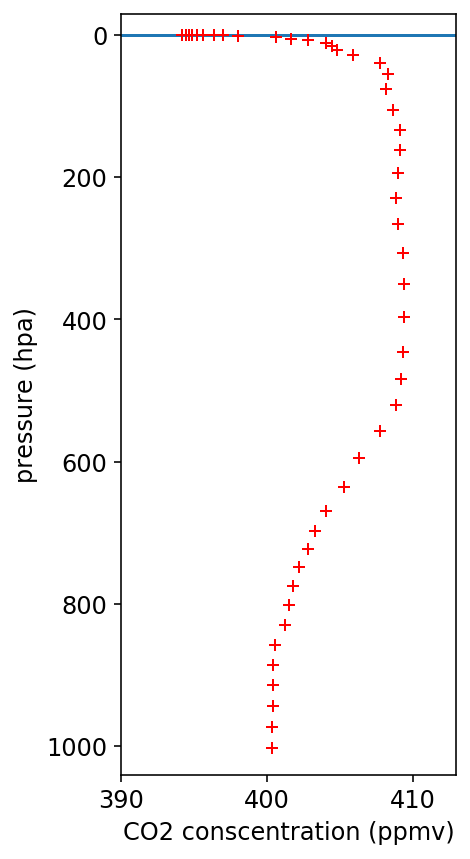

In [109]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 9442
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

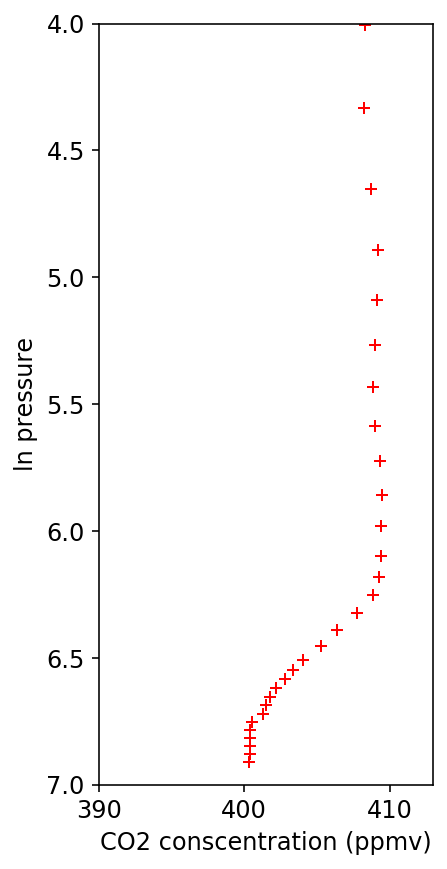

In [110]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

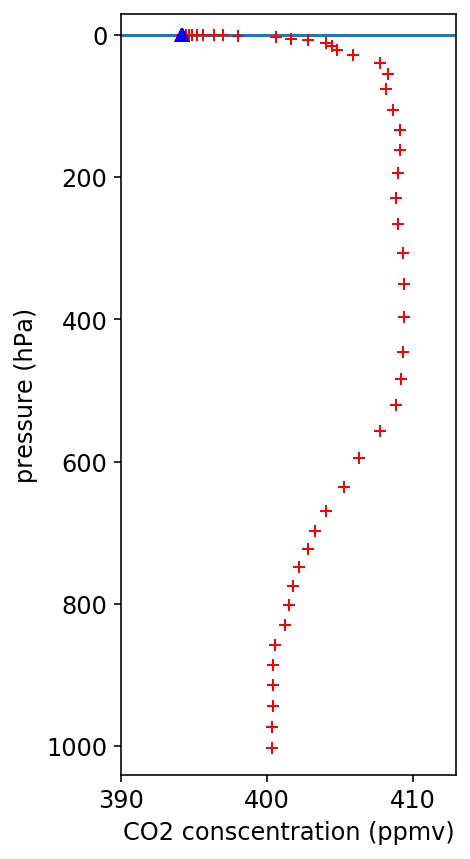

In [111]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [112]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 393120)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [113]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])
needed_vars

array(['SpeciesConc_CO2'], dtype='<U32')

In [114]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_model.levels])
tmp = tmp.astype(dtype = 'float32')
print(tmp)
for ivar in needed_vars: interpolated[ivar] = tmp.copy()
interpolated

<xarray.DataArray (record: 393120, levels: 47)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119
  * levels   (levels) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05


<xarray.Dataset>
Dimensions:          (levels: 20, record: 393120)
Coordinates:
  * levels           (levels) float64 0.0001 0.05263 0.1053 ... 0.9474 1.0
  * record           (record) int64 0 1 2 3 4 ... 393116 393117 393118 393119
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 nan nan nan nan ... nan nan nan

In [115]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values) # log space
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

3891
4035
4060
4061
4080
4100
4120
4150
4169
4179
4204
4224
4244
4264
4323
4348
4427
4467
4531
4532
4542
4551
4571
4591
4610
4636
4675
4686
4695
4715
4726
4735
4745
4780
4819
4830
4839
4859
4869
4878
4879
4888
4923
4963
4974
4983
5002
5003
5022
5032
5067
5117
5127
5146
5166
5176
5211
5251
5261
5270
5271
5310
5320
5345
5355
5395
5405
5414
5454
5464
5489
5499
5538
5549
5558
5578
5598
5617
5633
5643
5682
5702
5722
5742
5761
5777
5786
5787
5817
5826
5846
5866
5905
5920
5921
5930
5961
5970
5990
6009
6020
6039
6049
6064
6074
6104
6114
6133
6134
6153
6164
6183
6193
6208
6218
6257
6258
6277
6297
6327
6336
6337
6352
6362
6401
6421
6441
6471
6480
6506
6545
6565
6585
6614
6624
6640
6649
6650
6689
6758
6768
6793
6853
6872
6937
7016
7140
7245
7359
7388
7503
7532
7562
7611
7646
7676
7746
7755
7765
7790
7820
7859
7870
7890
7899
7909
7934
7964
8043
8053
8078
8088
8107
8108
8127
8196
8197
8206
8221
8222
8271
8321
8340
8350
8415
8465
8484
8494
8559
8589
8628
8638
8663
8702
8722
8733
8762
8772
8781
8797


57515
57516
57525
57536
57575
57576
57585
57604
57620
57630
57659
57669
57680
57689
57709
57728
57729
57748
57764
57773
57774
57803
57813
57823
57824
57833
57853
57872
57892
57907
57917
57947
57957
57967
57996
58016
58036
58051
58061
58081
58091
58101
58111
58120
58121
58140
58160
58170
58180
58195
58205
58225
58235
58244
58245
58255
58264
58284
58314
58323
58324
58339
58349
58378
58388
58399
58408
58428
58438
58458
58467
58483
58493
58522
58532
58543
58552
58572
58601
58611
58627
58636
58637
58666
58676
58686
58687
58696
58716
58726
58755
58770
58780
58810
58820
58859
58889
58914
58924
58954
58964
59003
59014
59023
59058
59068
59098
59108
59147
59167
59186
59202
59212
59320
59321
59330
59346
59375
59385
59464
59474
59489
59490
59500
59529
59618
59633
59663
59807
59921
59931
59990
60040
60049
60065
60075
60094
60095
60104
60134
60174
60183
60184
60193
60209
60219
60238
60248
60278
60317
60327
60337
60362
60373
60382
60392
60422
60461
60471
60481
60496
60506
60517
60565
60566
60605
6061

103513
103514
103623
103804
103805
104076
108649
108878
108917
109022
109061
109071
109081
109131
109160
109165
109175
109205
109215
109225
109235
109244
109264
109275
109304
109309
109349
109359
109368
109369
109379
109388
109408
109453
109463
109502
109523
109532
109552
109562
109563
109572
109597
109607
109617
109656
109667
109676
109696
109706
109715
109716
109735
109750
109751
109760
109800
109810
109811
109820
109840
109850
109859
109879
109884
109885
109894
109934
109954
109964
109994
110003
110013
110023
110028
110038
110088
110098
110138
110147
110167
110172
110182
110192
110202
110212
110222
110231
110232
110242
110251
110282
110291
110301
110310
110311
110316
110336
110346
110355
110356
110365
110375
110386
110395
110435
110444
110445
110454
110460
110470
110480
110499
110509
110519
110530
110539
110578
110579
110588
110604
110613
110614
110623
110624
110643
110653
110663
110673
110674
110722
110742
110747
110748
110757
110767
110797
110807
110817
110827
110846
110857
110866

148688
148697
148717
148728
148737
148747
148772
148782
148821
148832
148841
148871
148881
148890
148891
148900
148916
148925
148926
148955
148965
148976
148985
149005
149015
149024
149069
149099
149109
149119
149120
149129
149148
149168
149178
149213
149243
149253
149263
149272
149273
149322
149332
149347
149357
149387
149397
149407
149416
149466
149475
149476
149491
149501
149530
149540
149551
149560
149580
149610
149619
149635
149645
149674
149684
149695
149724
149744
149763
149788
149789
149818
149828
149838
149839
149868
149887
149907
149922
149923
149932
149962
149972
149982
150011
150012
150031
150051
150066
150076
150116
150126
150166
150175
150195
150210
150220
150260
150270
150319
150338
150339
150354
150364
150384
150393
150394
150403
150414
150443
150482
150498
150508
150537
150547
150558
150587
150616
150617
150626
150642
150651
150652
150681
150691
150711
150731
150750
150760
150770
150785
150786
150795
150825
150835
150855
150874
150875
150894
150904
150914
150929
150939

190089
190104
190144
190183
190203
190248
190288
190327
190347
190471
190520
190635
190664
190680
190699
190730
190808
190823
190863
190873
190922
190952
190967
191057
191096
191101
191111
191131
191239
191245
191255
191275
191294
191373
191374
191389
191399
191418
191419
191438
191527
191533
191553
191582
191661
191671
191676
191697
191706
191726
191805
191820
191840
191841
191850
191870
191949
191964
191984
192013
192073
192092
192093
192108
192128
192157
192177
192216
192217
192236
192251
192252
192272
192281
192301
192311
192321
192331
192360
192380
192395
192405
192416
192425
192445
192455
192464
192465
192475
192504
192533
192559
192560
192589
192599
192608
192619
192648
192677
192693
192703
192712
192732
192743
192752
192772
192791
192792
192821
192836
192847
192876
192886
192887
192896
192906
192915
192926
192980
192991
193020
193030
193039
193050
193059
193070
193124
193134
193135
193194
193203
193213
193214
193267
193337
193338
193346
193347
193357
193377
193411
193442
193481

229656
229685
229701
229740
229780
229800
229829
229884
229924
229963
229973
229979
230028
230107
230117
230132
230172
230251
230261
230266
230276
230296
230316
230346
230395
230420
230440
230460
230490
230539
230564
230603
230633
230634
230682
230698
230708
230718
230747
230767
230826
230841
230842
230851
230891
230911
230970
230985
230995
231035
231054
231055
231065
231114
231123
231124
231139
231149
231178
231198
231209
231238
231258
231267
231293
231322
231333
231342
231353
231362
231382
231401
231411
231417
231426
231427
231437
231466
231477
231486
231506
231525
231526
231555
231560
231561
231570
231581
231590
231610
231620
231630
231649
231650
231660
231689
231699
231704
231714
231725
231734
231754
231773
231784
231793
231804
231833
231842
231848
231858
231868
231869
231878
231897
231917
231928
231937
231977
231992
232002
232012
232021
232041
232061
232071
232072
232081
232156
232165
232204
232205
232215
232235
232244
232300
232309
232348
232388
232423
232472
232492
232512
232531

267700
267715
267746
267755
267775
267794
267814
267825
267834
267844
267859
267889
267899
267918
267919
267938
267958
267978
267987
267988
268003
268042
268043
268062
268082
268122
268131
268147
268186
268226
268265
268275
268291
268321
268330
268389
268409
268419
268434
268435
268465
268474
268544
268553
268578
268609
268618
268722
268742
268762
268841
268866
268905
268906
268936
269154
269184
269193
269233
269253
269297
269377
269540
269585
269684
269713
269729
269848
269857
269873
269893
269991
270001
270016
270017
270036
270056
270135
270145
270160
270180
270200
270279
270289
270304
270324
270344
270432
270448
270468
270487
270488
270507
270518
270527
270592
270602
270631
270642
270651
270671
270720
270735
270736
270746
270775
270814
270815
270825
270879
270890
270919
270958
271023
271033
271034
271043
271063
271082
271102
271132
271167
271177
271186
271187
271226
271237
271246
271257
271266
271310
271321
271370
271389
271390
271465
271514
271533
271553
271564
271608
271609
271657

307584
307599
307600
307609
307619
307630
307639
307649
307659
307669
307743
307753
307763
307774
307783
307793
307803
307853
307887
307897
307907
307917
307927
307937
307947
308006
308031
308041
308071
308080
308150
308175
308185
308205
308462
308472
308482
308512
308616
308626
308705
308725
308760
308770
308869
308904
308914
309013
309048
309058
309157
309166
309182
309192
309310
309320
309325
309345
309454
309464
309469
309489
309588
309598
309607
309608
309613
309652
309653
309662
309663
309732
309741
309742
309751
309757
309796
309806
309836
309875
309885
309895
309901
309920
309940
309950
309980
310019
310029
310039
310044
310064
310084
310094
310123
310124
310163
310173
310183
310188
310208
310228
310237
310238
310247
310248
310258
310267
310307
310317
310332
310352
310371
310372
310381
310411
310431
310451
310470
310476
310495
310496
310515
310555
310575
310614
310619
310639
310650
310659
310679
310689
310698
310699
310718
310748
310773
310793
310794
310803
310822
310842
310882

347543
347563
347612
347622
347628
347637
347638
347667
347707
347727
347756
347766
347781
347850
347900
347910
347915
347925
347985
348044
348054
348069
348079
348099
348108
348197
348203
348213
348252
348347
348357
348386
348446
348490
348491
348500
348530
348589
348629
348634
348644
348674
348753
348772
348773
348778
348788
348798
348818
348828
348848
348916
348922
348942
348961
348962
348971
348992
349001
349031
349040
349041
349050
349051
349060
349066
349115
349135
349145
349175
349184
349194
349204
349209
349210
349229
349269
349279
349319
349328
349338
349348
349353
349373
349403
349413
349423
349472
349497
349517
349527
349537
349546
349547
349556
349576
349587
349616
349626
349635
349641
349660
349661
349671
349680
349690
349700
349720
349730
349731
349759
349760
349769
349779
349784
349794
349804
349824
349844
349864
349874
349883
349894
349923
349928
349938
349948
349978
349988
350007
350018
350027
350038
350072
350082
350092
350111
350112
350121
350142
350151
350162
350181

In [116]:
max(record)

393119

In [117]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

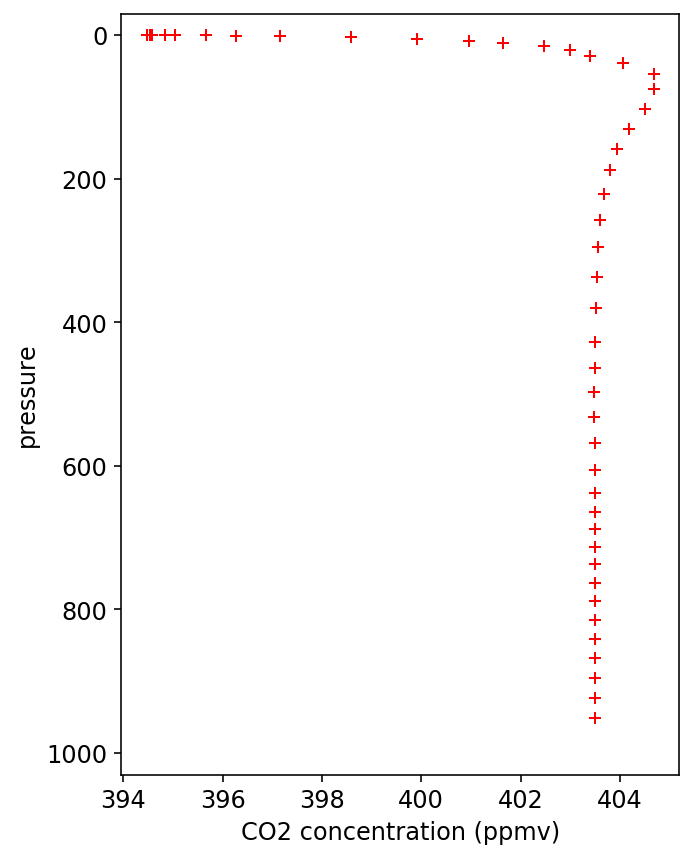

In [118]:
# after interpolation
irecord = 80503
varname = 'SpeciesConc_CO2'
x_co2_after    = interpolated[varname][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model[varname][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
#ax.set_xlim(390,413)
ax.set_xlabel('CO2 concentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [119]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [120]:
interpolated

<xarray.Dataset>
Dimensions:          (levels: 20, record: 393120)
Coordinates:
  * levels           (levels) float64 0.0001 0.05263 0.1053 ... 0.9474 1.0
  * record           (record) int64 0 1 2 3 4 ... 393116 393117 393118 393119
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 nan nan nan nan ... nan nan nan
    lat              (record) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon              (record) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
    date             (record) datetime64[ns] 2018-06-01 ... 2018-06-30
Attributes:
    comment:  interpolated from 47 level model outputs